Magic for inline plots

In [1]:
%matplotlib inline

I like to use pandas module for exploring and cleaning data.
I will also use pyplot for genearting multiple plots, and seaborn for correlation heatmap. Since I will also run PCA, I will import it form sklearn.

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

Lets read data files provided with this problem.

In [3]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
sampleSubmission = pd.read_csv("../input/sampleSubmission.csv")

Usually, the train dataset have extra collumns which are not present in test dataset. Lets identify them.

In [4]:
set(train.columns) - set(test.columns)

{'casual', 'count', 'registered'}

Hmmm. What is interesting, it seems that train dataset has three extra collumns. Usually we are expecting one extra collumn. Lets try to guess which collum will be most interesting for us. **Fun fact**: since this is Kaggle competition, there should be clear description of data we should predict and precise description of datasets for train and test. I'm just pretending that my Internet connection is broken and I have only those three files ;)

In [5]:
set(sampleSubmission.columns) - set(test.columns)

{'count'}

Ok, so it seems that there are no **casual, count, registered** columns in train dataset, but we are practically interested only in **count** column.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x647d4d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x6787ad0>]], dtype=object)

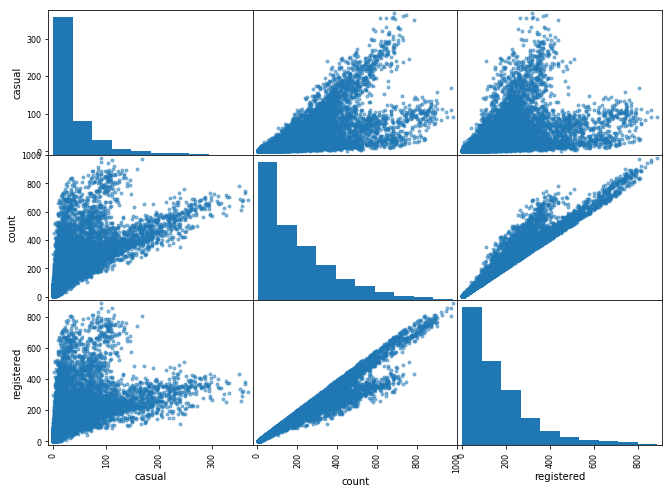

In [6]:
pd.tools.plotting.scatter_matrix(train[["casual", "count", "registered"]], figsize=(11, 8))

Based on above plots, it seems that **registered** column is related to **count** column. And what's about **casual** column? It also seems to be related. Maybe we should chcekc if **casual** and **registered** sums to **count**?

In [7]:
(train["count"] == train["registered"] + train["casual"]).value_counts()

True    10886
dtype: int64

We have total 10886 equal sums, which should correspond to number of rows in our train dataset.

In [8]:
numericalColumns = train.describe()
numericalColumns

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


As we can see above, columns **registered** and **casual** sum into value located in **count** column.

In [9]:
print(set(train.columns) - set(numericalColumns))
train["datetime"].head()

set(['datetime'])


0    2011-01-01 00:00:00
1    2011-01-01 01:00:00
2    2011-01-01 02:00:00
3    2011-01-01 03:00:00
4    2011-01-01 04:00:00
Name: datetime, dtype: object

Apart of typical numerical columns, there is one column interpreted as "object". I can assume that this should be datetime column. Lets convert it and see basic description.

In [10]:
train["datetime"] = pd.to_datetime(train["datetime"])
train["datetime"].describe()

count                   10886
unique                  10886
top       2011-06-09 04:00:00
freq                        1
first     2011-01-01 00:00:00
last      2012-12-19 23:00:00
Name: datetime, dtype: object

Since we have datetime column now, maybe we should break it apart on different parts and 

In [11]:
train["dayofweek"] = train["datetime"].dt.dayofweek      #The day of the week with Monday=0, Sunday=6
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second

Lets describe newly created columns.

In [12]:
train[["dayofweek", "year", "month", "day", "hour", "minute", "second"]].describe()

,dayofweek,year,month,day,hour,minute,second
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.0,10886.0
mean,3.013963,2011.501929,6.521495,9.992559,11.541613,0.0,0.0
std,2.004585,0.500019,3.444373,5.476608,6.915838,0.0,0.0
min,0.000000,2011.000000,1.000000,1.000000,0.000000,0.0,0.0
25%,1.000000,2011.000000,4.000000,5.000000,6.000000,0.0,0.0
50%,3.000000,2012.000000,7.000000,10.000000,12.000000,0.0,0.0
75%,5.000000,2012.000000,10.000000,15.000000,18.000000,0.0,0.0
max,6.000000,2012.000000,12.000000,19.000000,23.000000,0.0,0.0


Ok, so as we expected, **dayoftheweek** contains vales from 0 to 6. **year** contains to years, **month** has 12 values. **hour** has values from 0 to 23. Interesting is that **day** column has values from 1 to 19, which is suspicious. **minute** and **second** columns have only one value. That hint us, that resolution of data poins is limited to hour. We should prepare the same analysis for test datafile.

In [13]:
test["datetime"] = pd.to_datetime(test["datetime"])
test["dayofweek"] = test["datetime"].dt.dayofweek      #The day of the week with Monday=0, Sunday=6
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second

In [14]:
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,dayofweek,year,month,day,hour,minute,second
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.0,6493.0
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157,3.007239,2011.503619,6.565070,25.224550,11.555367,0.0,0.0
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151,1.997714,0.500025,3.429462,3.339411,6.912526,0.0,0.0
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000,0.000000,2011.000000,1.000000,20.000000,0.000000,0.0,0.0
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500,1.000000,2011.000000,4.000000,22.000000,6.000000,0.0,0.0
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400,3.000000,2012.000000,7.000000,25.000000,12.000000,0.0,0.0
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900,5.000000,2012.000000,10.000000,28.000000,18.000000,0.0,0.0
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600,6.000000,2012.000000,12.000000,31.000000,23.000000,0.0,0.0


After quick eye examination we can catch, that column **day** in test dataset starts from 20 and ends to 31. This fact gives us information that we probably want to predict **count** value in last 11 or 12 days in month. And this conclusion is correct accoriding to competition description. We can also see, that **minute** and **second** column don't have other values than *0* so we can discard them from further analysis.

In [15]:
train = train.drop(["minute", "second"], axis = 1)
test = test.drop(["minute", "second"], axis = 1)

Ok, it may be good time for some histograms.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x6b87850>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7d37c10>]], dtype=object)

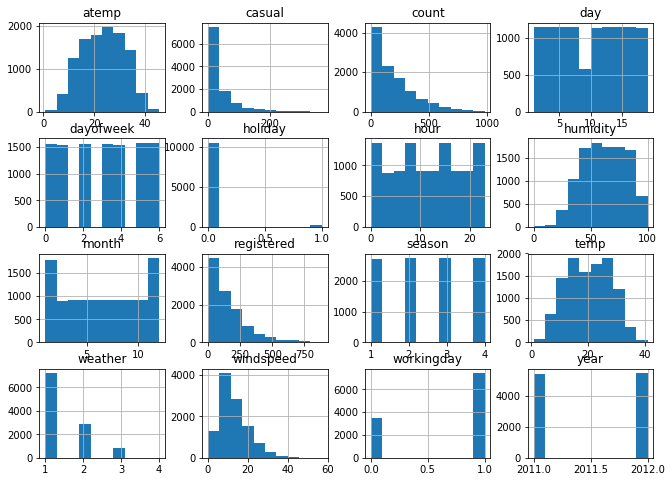

In [16]:
train.hist(figsize=(11, 8))

Lets write function which will help us with plotting values form features grouped by hours and run it over all features which have no more than 10 unique values. 

In [120]:
def plotByFeature (df, feature):
    values_number = df[feature].unique().size
    if values_number <= 10:
        print("Plot for feature {0}:".format(feature))
        for value in df[feature].unique():
            df[df[feature] == value].groupby("hour")["count"].sum().plot(label = value, legend = True, grid = True, title = feature)
        plt.show()
    else:
        print("Feature {0} has too many unique values, skipping!".format(feature))

Feature datetime has too many unique values, skipping!
Plot for feature season:


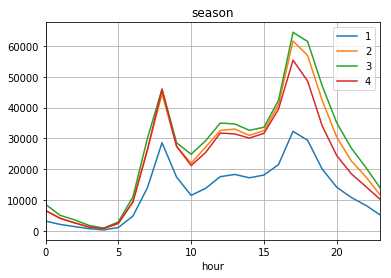

Plot for feature holiday:


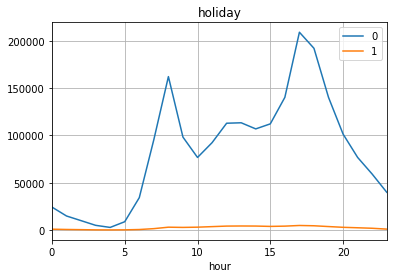

Plot for feature workingday:


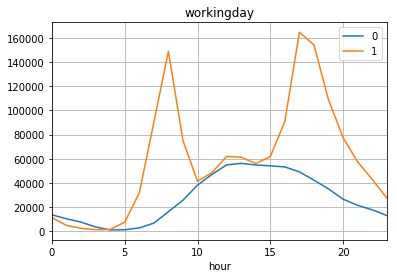

Plot for feature weather:


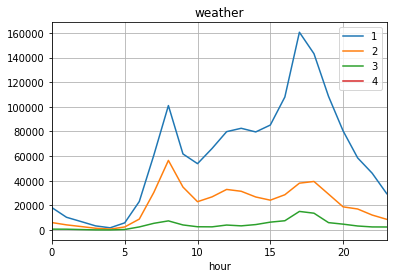

Feature temp has too many unique values, skipping!
Feature atemp has too many unique values, skipping!
Feature humidity has too many unique values, skipping!
Feature windspeed has too many unique values, skipping!
Feature casual has too many unique values, skipping!
Feature registered has too many unique values, skipping!
Feature count has too many unique values, skipping!
Plot for feature dayofweek:


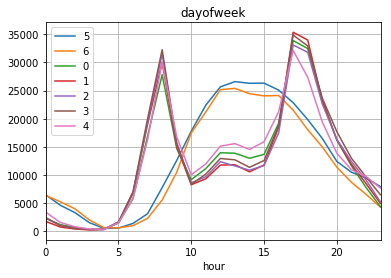

Plot for feature year:


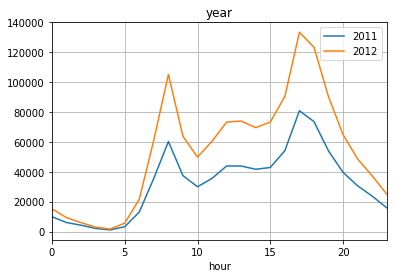

Feature month has too many unique values, skipping!
Feature day has too many unique values, skipping!
Feature hour has too many unique values, skipping!


In [121]:
for feature in train.columns:
    plotByFeature(train, feature)

Based on above plots, I can make two assumptions: **workingday** plots totally different plots, so bike usage might be completly different on weekends than on workdays. It also seems that **wather** may affect bike borrowing.

Lest also plot correlations.

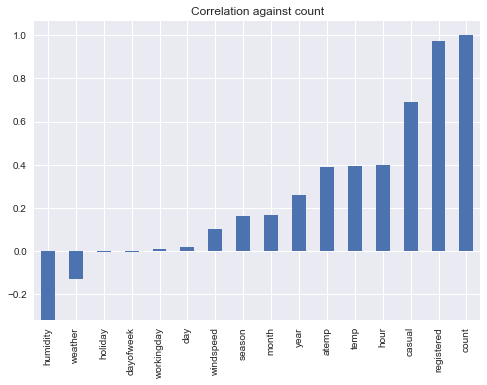

In [145]:
train.corr().sort_values(by="count")["count"].plot(kind = 'bar', title = "Correlation against count")

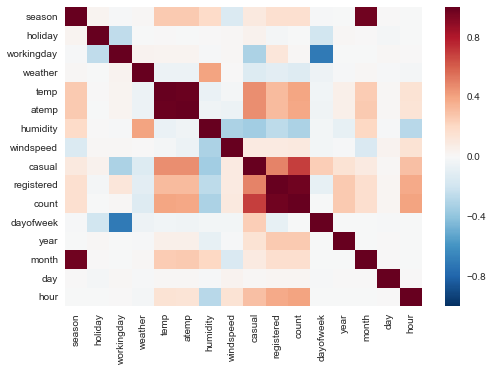

In [148]:
sns.heatmap(train.corr())

We can also run principal component analysis on numerical features to see how much of them gives us information about variation of our data set. 

In [180]:
train_pca = train.drop(['datetime', 'registered', 'casual', 'count'], 1)

I will run PCA for various number of target components and see which number will give us reasonable information.

In [194]:
explained = []

for num_features in range(1,len(train_pca.columns)+1):
    pca = PCA(n_components=num_features)
    pca.fit(train_pca)
    explained.append(pca.explained_variance_ratio_.sum())

In [196]:
explained

[0.57695988281551347,
 0.77775071392200801,
 0.86629345298733351,
 0.92930774468478328,
 0.97424038081983533,
 0.99126378696064865,
 0.9974454616149574,
 0.99885122831767803,
 0.99933578056853622,
 0.99970535705533947,
 0.9998808057640941,
 0.99997497578469152,
 0.99999999999999989]

It looks like first 6 components after PCA handles explains over 99% of data variance. We can also plot it.

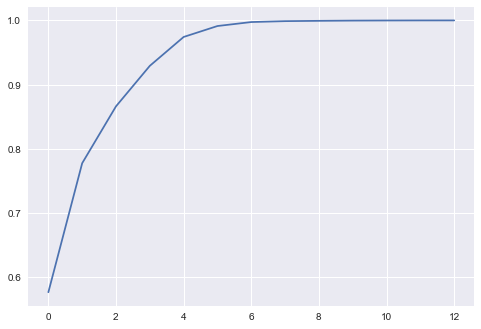

In [198]:
plt.plot(explained)